In [1]:
# to download the model weight from google drive
! gdown --id # ID

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1F2mkBy1nfJctxBRCO8weWOjUAG_kAvBq
To: /content/resnet_38epochs.pkl
100% 63.7M/63.7M [00:00<00:00, 187MB/s]


In [2]:
!pip install datasets
!pip install hexbytes

In [6]:
import math
from PIL import Image
import tqdm
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset, disable_caching
import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
from torch.nn.functional import normalize
from torchvision import transforms, models
from hexbytes import HexBytes
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, multilabel_confusion_matrix

In [7]:
datasets.config.IN_MEMORY_MAX_SIZE = 10000

In [8]:
disable_caching()

In [9]:
BATCH_SIZE = 8
DEVICE = 'cuda'
MODEL_NAME = 'resnet'
NUM_CLASSES = 5
WEIGHT_FILE_NAME = 'resnet_38epochs.pkl'


IMG_SIZE = 224
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

In [10]:
SAFE_IDX = 4 # the index of safe smart contract

def __get_RGB_image(bytecode):
    image = np.frombuffer(bytecode, dtype=np.uint8)
    length = int(math.ceil(len(image)/3))
    image = np.pad(image, pad_width=(0, length*3 - len(image)))
    image = image.reshape((-1, 3))
    sqrt_len = int(math.ceil(math.sqrt(image.shape[0])))
    image = np.pad(image,  pad_width=((0, sqrt_len**2 - image.shape[0]),(0,0)))
    image = image.reshape((sqrt_len, sqrt_len, 3))
    image = Image.fromarray(image)
    return image

def __get_one_hot_encoded_label(label):
    one_hot = np.zeros(5)
    for elem in label:
        if elem < SAFE_IDX:
            one_hot[elem] = 1
        elif elem > SAFE_IDX:
            one_hot[elem-1] = 1
    return one_hot

def generate_image_and_label(example):
    code = HexBytes(example['bytecode'])
    example['image'] = __get_RGB_image(code)
    example['label'] = __get_one_hot_encoded_label(example['slither'])
    return example

In [11]:
img_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

def img_label_to_tensor(examples):
    examples['image'] = [img_transform(elem) for elem in examples['image']]
    examples['label'] = torch.tensor(examples['label'])
    return examples

In [12]:
test_ds = load_dataset("mwritescode/slither-audited-smart-contracts", 'big-multilabel', split='test', ignore_verifications=True)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:2491: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=no_checks' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for mwritescode/slither-audited-smart-contracts contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/mwritescode/slither-audited-smart-contracts
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [13]:
test_ds.cleanup_cache_files()
test_ds = test_ds.filter(lambda elem: elem['bytecode'] != '0x')
test_ds = test_ds.map(generate_image_and_label, remove_columns=['address', 'source_code', 'bytecode', 'slither'])
test_ds.set_transform(img_label_to_tensor)

Filter:   0%|          | 0/15972 [00:00<?, ? examples/s]

Map:   0%|          | 0/15921 [00:00<?, ? examples/s]

In [9]:
# val_ds = load_dataset("mwritescode/slither-audited-smart-contracts", 'big-multilabel', split='validation', ignore_verifications=True, cache_dir="./")
# val_ds = val_ds.filter(lambda elem: elem['bytecode'] != '0x')
# val_ds = val_ds.map(generate_image_and_label, remove_columns=['address', 'source_code', 'bytecode', 'slither'])
# val_ds.set_transform(img_label_to_tensor)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:2491: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=no_checks' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for mwritescode/slither-audited-smart-contracts contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/mwritescode/slither-audited-smart-contracts
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Filter:   0%|          | 0/10861 [00:00<?, ? examples/s]

Map:   0%|          | 0/10831 [00:00<?, ? examples/s]

In [14]:
# loader_val = DataLoader(val_ds,
#                         batch_size=BATCH_SIZE)
loader_test = DataLoader(test_ds,
                        batch_size=BATCH_SIZE)

In [15]:
del test_ds

In [16]:
class Model(nn.Module):
    def __init__(self, model_name='resnet', num_classes=5):
        super(Model, self).__init__()
        if model_name == 'resnet':
          self.resnet = models.resnet18(pretrained=True)
          self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)
        elif model_name == 'densenet':
          self.model = models.densenet121(pretrained=True)
          self.model.classifier = nn.Linear(self.model.classifier.in_features, num_classes)
        elif model_name == 'alexnet':
          self.model = models.alexnet(pretrained=True)
          self.model.classifier[6] = nn.Linear(4096, num_classes)
        elif model_name == "vgg":
          self.model = models.vgg11_bn(pretrained=True)
          self.model.classifier[6] = nn.Linear(self.model.classifier[6].in_features, num_classes)

    def forward(self, inputs):
        return self.resnet(inputs)


    def get_layer_groups(self):
        linear_layers = [elem[1] for elem in filter(lambda param_tuple: 'fc' in param_tuple[0], self.resnet.named_parameters())]
        other_layers = [elem[1] for elem in filter(lambda param_tuple: 'fc' not in param_tuple[0], self.resnet.named_parameters())]
        param_groups = {
            'classifier': linear_layers,
            'feature_extractor': other_layers
        }
        return param_groups

In [17]:
model = Model(model_name=MODEL_NAME, num_classes=NUM_CLASSES)
device = torch.device('cuda')
checkpoint = torch.load(WEIGHT_FILE_NAME)
# model.load_state_dict(checkpoint)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [18]:
del checkpoint

In [19]:
total_preds = []
total_gt = []
metrics = {'acc': accuracy_score, 'f1_score': f1_score, 'precision': precision_score, 'recall': recall_score}
logs = dict()
del logs

running_metrics = {metric: 0.0 for metric in metrics.keys()}
logs = {'batch_idx': 0} | {'test_' + metric: 0.0 for metric in metrics.keys()}

with torch.no_grad():  # Disable gradient tracking during inference
    for batch in tqdm.tqdm(loader_test):
        images, labels = batch['image'].to(device), batch['label'].to(device)

        preds = model(images)
        preds = (preds >= 0.0).float()  # Use torch operations directly

        for metric_name, metric_func in metrics.items():
            if metric_name == 'acc':
                running_metrics[metric_name] += metric_func(labels.tolist(), preds.tolist())
            else:
                running_metrics[metric_name] += metric_func(labels.tolist(), preds.tolist(), average='micro')
            logs['test_' + metric_name] = running_metrics[metric_name] / (logs['batch_idx'] + 1)

        logs['batch_idx'] += 1
        total_preds.append(list(preds.cpu().numpy()))
        total_gt.append(list(batch['label'].numpy()))

        del images, labels, preds
        torch.cuda.empty_cache()

y_pred = np.concatenate(total_preds, axis=0)
y_true = np.concatenate(total_gt, axis=0)

100%|██████████| 1991/1991 [01:29<00:00, 22.24it/s]


In [20]:
logs

{'batch_idx': 1991,
 'test_acc': 0.6248116524359618,
 'test_f1_score': 0.7271205546140594,
 'test_precision': 0.7900087873427655,
 'test_recall': 0.6968941368250793}

In [23]:
LABEL_NAMES = ['access-control', 'arithmetic', 'other', 'reentrancy', 'unchecked-calls']
print(classification_report(y_true, y_pred, target_names=LABEL_NAMES, zero_division=0))

                 precision    recall  f1-score   support

 access-control       0.66      0.63      0.65      2331
     arithmetic       0.72      0.55      0.62      2708
          other       0.70      0.66      0.68      4193
     reentrancy       0.84      0.71      0.77      4838
unchecked-calls       0.88      0.79      0.83      7276

      micro avg       0.79      0.70      0.74     21346
      macro avg       0.76      0.67      0.71     21346
   weighted avg       0.79      0.70      0.74     21346
    samples avg       0.47      0.45      0.45     21346



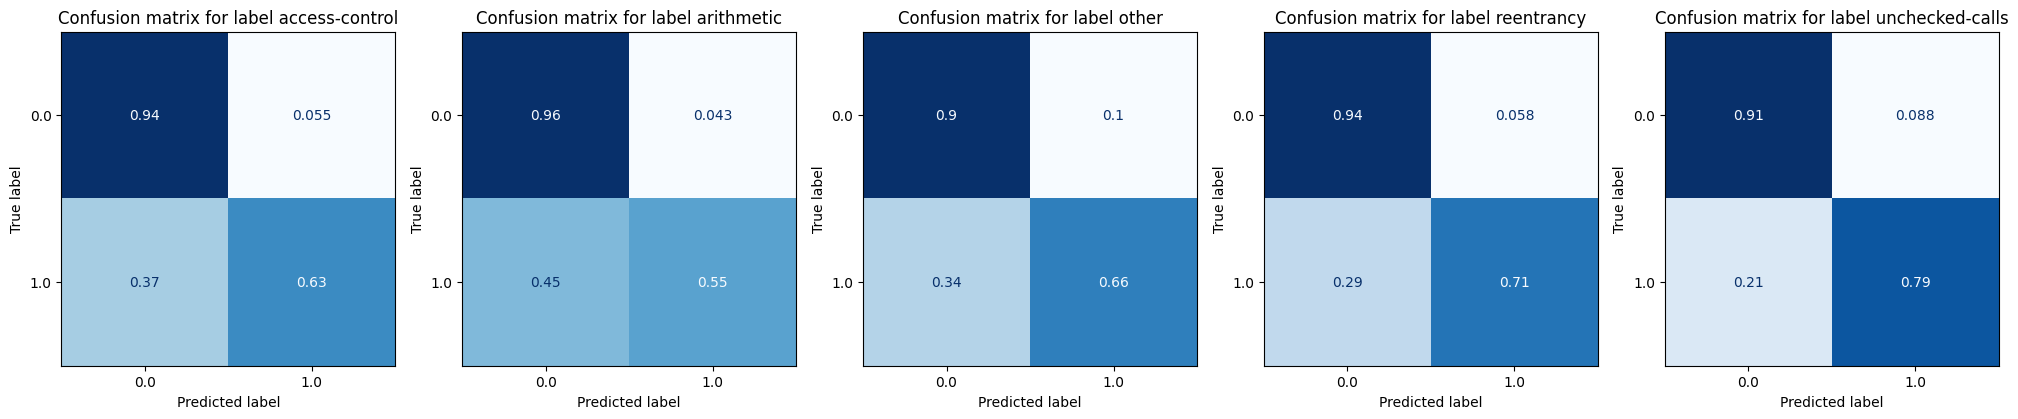

In [25]:
_, axs = plt.subplots(1, len(LABEL_NAMES), figsize=(25, 10))
conf_mat_dict={}

for label_col, ax in zip(range(len(LABEL_NAMES)), axs):
    y_true_label = y_true[:, label_col]
    y_pred_label = y_pred[:, label_col]
    ax.set_title("Confusion matrix for label " + LABEL_NAMES[label_col])
    ConfusionMatrixDisplay.from_predictions(y_true_label, y_pred_label, ax=ax, cmap=plt.cm.Blues, normalize='true', colorbar=False)

plt.show()